# Prep

## Imports & Paths

In [2]:
# psnr_hvsm for PSNR-HVS-M
!pip install psnr_hvsm

# PyTorch + PIQ for IW-SSIM and FSIM
!pip install piq

In [3]:
from PIL import Image
from google.colab import userdata

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn
import json
import os

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print(line)
    return

In [4]:
project_path = userdata.get('PATH_PROJECT')
dataset_path = os.path.join(project_path, 'dataset')
reg_dataset_path = os.path.join(dataset_path, 'regression_dataset')

train_path = os.path.join(dataset_path, 'train_metadata.json')
test_path = os.path.join(dataset_path, 'test_metadata.json')

src_path = os.path.join(project_path, 'src')
import sys
if not src_path in sys.path:
    sys.path.append(src_path)

## Load all images to the CPU

In [5]:
from tqdm import tqdm
import cv2

# Pre-load images into dictionaries
print("Pre-loading images...")
image_dirs = [os.path.join(dataset_path, image_dir) for image_dir in ['clean', 'new', 'ref']]
loaded_images_dict = dict()

for dir_path in image_dirs:
    if os.path.exists(dir_path):
        print(f"Loading dir: {str.split(dir_path, '/')[-1]}")
        for filename in tqdm(os.listdir(dir_path), desc="Loading images"):
            file_id = os.path.splitext(filename)[0]
            file_path = os.path.join(dir_path, filename)
            img = cv2.imread(file_path, cv2.IMREAD_COLOR_RGB)
            if img is not None:
                loaded_images_dict[file_id] = img

        print() # After sameline print in loop

print(f"Finished pre-loading {len(loaded_images_dict)} images.")

Pre-loading images...
Loading dir: clean


Loading images: 100%|██████████| 1849/1849 [00:30<00:00, 59.93it/s] 



Loading dir: new


Loading images: 100%|██████████| 2861/2861 [00:50<00:00, 56.34it/s] 



Loading dir: ref


Loading images: 100%|██████████| 2820/2820 [00:36<00:00, 76.48it/s] 


Finished pre-loading 7530 images.


## Get the dataset metadata

In [6]:
dataset_metadata_path = os.path.join(dataset_path, "dataset_metadata.json")
dataset_metadata = pd.read_json(dataset_metadata_path)

dataset_metadata.head()

,unique_sample_id,clean_image,distorted_image,score,metadata
0,new_Fuziki_case10_2789_2650,4547604,4547601,0.0,"{'crop_id': 4547601, 'image_source': 'Fuziki',..."
1,ref_Fuziki_case10_2789_2650,4547604,4547602,0.5,"{'crop_id': 4547602, 'image_source': 'Fuziki',..."
2,blended_new_Fuziki_case10_2789_2650,4547604,45476015,0.5,"{'crop_id': 4547601, 'image_source': 'Fuziki',..."
3,new_Fuziki_case10_1057_1620,4547612,4547609,0.0,"{'crop_id': 4547609, 'image_source': 'Fuziki',..."
4,ref_Fuziki_case10_1057_1620,4547612,4547610,0.5,"{'crop_id': 4547610, 'image_source': 'Fuziki',..."


## Create the features DataFrame


In [7]:
data = {
    'clean_image': dataset_metadata['clean_image'].astype(str),
    'distorted_image': dataset_metadata['distorted_image'].astype(str),
    'method': dataset_metadata['metadata'].apply(lambda meta: meta['method']),
    'score': dataset_metadata['score'],
}
features_df = pd.DataFrame(data=data).set_index(['clean_image', 'distorted_image'])

display(features_df)
display(features_df.info())
display(features_df['score'].value_counts().sort_index())

method  score
clean_image distorted_image              
4547604     4547601            new    0.0
            4547602            ref    0.5
            45476015           new    0.5
4547612     4547609            new    0.0
            4547610            ref    0.5
...                            ...    ...
4656822     4656820            ref    0.5
            46568195           new    0.5
4656922     4654575            new    0.0
            4656921            ref    1.0
            46545755           new    0.5

[5681 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5681 entries, ('4547604', '4547601') to ('4656922', '46545755')
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   method  5681 non-null   object 
 1   score   5681 non-null   float64
dtypes: float64(1), object(1)
memory usage: 363.5+ KB


None

,count
score,
0.0,1983
0.5,2607
1.0,1091


# Features

Based on research with Claude:
1. Pixel-Based/Statistical: PSNR (PSNR)
2. Structural Similarity: IW-SSIM (Information Weighted SSIM)
3. Frequency Domain: PSNR-HVS-M (adapted for small images)
4. Gradient/Edge-Based: GMSD (Gradient Magnitude Similarity Deviation)
5. Perceptual Color Space: CIEDE2000 (ΔE2000)
6. Human Visual System: FSIM (Feature Similarity Index) for small images

## PSNR
Peak signal-to-noise ratio (Log-scaled MSE)

### Original PSNR

In [8]:
import numpy as np

def calculate_psnr_luma(img1: np.ndarray, img2: np.ndarray) -> float:
    """
    Canonical PSNR computed on luminance (grayscale) only.

    Inputs:
      - img1, img2: np.ndarray, shape (H,W,3), dtype=uint8 or float
    Output:
      - Single PSNR value (float, in dB)
    """
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same shape.")

    # Convert RGB to luminance (BT.601)
    def rgb2gray(img: np.ndarray) -> np.ndarray:
        return 0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]

    # Ensure float64 for calculations
    img1_gray = rgb2gray(img1.astype(np.float64))
    img2_gray = rgb2gray(img2.astype(np.float64))

    # Determine max pixel value
    max_pixel = 255.0 if img1.dtype == np.uint8 else 1.0

    # Compute MSE
    mse = np.mean((img1_gray - img2_gray) ** 2)
    if mse == 0:
        return float('inf')

    # Compute PSNR
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


# <-- Add column: PSNR -->

features_df['psnr'] = [
    calculate_psnr_luma(
        loaded_images_dict[clean_id],
        loaded_images_dict[distorted_id],
    )
    for clean_id, distorted_id in features_df.index
]

features_df.head(2)

method  score       psnr
clean_image distorted_image                         
4547604     4547601            new    0.0  29.502193
            4547602            ref    0.5  36.386263

### PSNR-HVS-M

In [197]:
import numpy as np

def _next_mult8(n: int) -> int:
    return ((n + 7) // 8) * 8

def _pad_to_mult8_2d(img2d: np.ndarray, mode: str = "reflect") -> np.ndarray:
    h, w = img2d.shape
    nh = _next_mult8(h)
    nw = _next_mult8(w)
    ph = nh - h
    pw = nw - w
    top = ph // 2
    bottom = ph - top
    left = pw // 2
    right = pw - left
    if ph == 0 and pw == 0:
        return img2d
    return np.pad(img2d, ((top, bottom), (left, right)), mode=mode)

def PSNR_HVS_M_luma(img1: np.ndarray, img2: np.ndarray, pad_mode: str = "reflect") -> float:
    """
    Canonical PSNR-HVS-M computed on luma (Y) channel (BT.601).
    Inputs:
      - img1, img2: numpy arrays shape (20,20,3), dtype=uint8, values 0..255
      - pad_mode: padding mode for np.pad (default 'reflect')
    Output:
      - psnr_hvsm: float (dB), PSNR-HVS-M computed on Y channel
    Notes:
      - Requires `psnr_hvsm` package: `pip install psnr_hvsm`
      - The function pads to multiples of 8 because the implementation works on 8x8 DCT blocks.
    """
    try:
        from psnr_hvsm import psnr_hvs_hvsm
    except Exception as e:
        raise ImportError("psnr_hvsm required. Install with: pip install psnr_hvsm") from e

    # convert to float [0,1]
    a = img1.astype(np.float64) / 255.0
    b = img2.astype(np.float64) / 255.0

    # BT.601 luma conversion (assuming RGB order)
    Y1 = 0.299 * a[..., 0] + 0.587 * a[..., 1] + 0.114 * a[..., 2]
    Y2 = 0.299 * b[..., 0] + 0.587 * b[..., 1] + 0.114 * b[..., 2]

    # pad to multiples of 8 (centered)
    Y1p = _pad_to_mult8_2d(Y1, mode=pad_mode)
    Y2p = _pad_to_mult8_2d(Y2, mode=pad_mode)

    # psnr_hvs_hvsm returns (psnr_hvs, psnr_hvsm)
    _, psnr_hvsm = psnr_hvs_hvsm(Y1p, Y2p)
    return float(psnr_hvsm)


# <-- Add column: PSNR-HVS-M -->

features_df["psnr_hvs_m"] = [
    PSNR_HVS_M_luma(
        loaded_images_dict[str(clean_id)],
        loaded_images_dict[str(distorted_id)]
    )
    for clean_id, distorted_id in features_df.index
]


features_df.head(2)

method  score  psnr_hvs_m
clean_image distorted_image                          
4547604     4547601            new    0.0   27.341491
            4547602            ref    0.5   38.338027

## SSIM (Structural Similarity Index Measure)

NOTE: MS-SSIM and IW SSIM are not applicable to 20x20 images.
We can attemp them if we allow resizing.


### Original SSIM

In [9]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

def compute_ssim_luma(clean_img: np.ndarray, distorted_img: np.ndarray) -> float:
    """
    Canonical SSIM computed on luminance (grayscale) only.

    Inputs:
      - clean_img, distorted_img: np.ndarray, shape (H,W,3), dtype uint8 or float
    Output:
      - Single SSIM value (float in [-1,1], typically [0,1])
    """
    if clean_img.shape != distorted_img.shape:
        raise ValueError("Input images must have the same shape.")

    # Convert RGB to luminance (BT.601)
    def rgb2gray(img: np.ndarray) -> np.ndarray:
        return 0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]

    gray_clean = rgb2gray(clean_img.astype(np.float64))
    gray_distorted = rgb2gray(distorted_img.astype(np.float64))

    # Compute SSIM on luminance
    return float(ssim(gray_clean, gray_distorted, data_range=gray_clean.max() - gray_clean.min()))


# <-- Add column: SSIM -->

features_df["ssim"] = [
    compute_ssim_luma(
        loaded_images_dict[str(clean_id)],
        loaded_images_dict[str(distorted_id)]
    )
    for clean_id, distorted_id in features_df.index
]


features_df.head(2)


method  score       psnr     ssim
clean_image distorted_image                                  
4547604     4547601            new    0.0  29.502193  0.92960
            4547602            ref    0.5  36.386263  0.98601

### IW-SSIM (Information Weighted SSIM)

In [162]:
%%skip Skipping IW-SSIM

import numpy as np

def IW_SSIM_luma(img1: np.ndarray, img2: np.ndarray,
                 device: str = "cpu") -> float:
    """
    Canonical IW-SSIM: computed on luminance only.
    (Original paper & MATLAB release compute on grayscale images.)

    Inputs:
      - img1, img2: np.ndarray shape (20,20,3), dtype=uint8, values in [0,255]
      - device: 'cpu' or 'cuda'

    Output:
      - Single IW-SSIM score (float in [-1,1], typically [0,1])

    Notes:
      - Requires torch + piq: pip install torch piq
    """
    try:
        import torch
        import piq
    except Exception as e:
        raise ImportError("Requires torch and piq. Install with: pip install torch piq") from e

    # Convert RGB to luminance (BT.601)
    def rgb2gray(img: np.ndarray) -> np.ndarray:
        return 0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]

    gray1 = rgb2gray(img1.astype(np.float32) / 255.0)
    gray2 = rgb2gray(img2.astype(np.float32) / 255.0)

    t1 = torch.from_numpy(gray1).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,H,W)
    t2 = torch.from_numpy(gray2).unsqueeze(0).unsqueeze(0).to(device)

    score = piq.information_weighted_ssim(t1, t2, data_range=1.0, reduction='mean')
    return float(score.detach().cpu().numpy())


# <--- Add column: IW-SSIM --->

features_df["iw_ssim"] = [
    IW_SSIM_luma(
        loaded_images_dict[str(clean_id)],
        loaded_images_dict[str(distorted_id)]
    )
    for clean_id, distorted_id in features_df.index
]

features_df.head(2)


Skipping IW-SSIM


## GMSD

In [174]:
import numpy as np
from scipy.ndimage import convolve

def GMSD_luma(img1: np.ndarray, img2: np.ndarray, c: float = 0.0026) -> float:
    """
    Canonical GMSD: computed on luminance only.

    Inputs:
      - img1, img2: np.ndarray shape (20,20,3), dtype=uint8
      - c: stability constant (default 0.0026)

    Output:
      - GMSD score (float, lower is better)
    """
    # Convert RGB to luminance (BT.601)
    def rgb2gray(img: np.ndarray) -> np.ndarray:
        return 0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]

    gray1 = rgb2gray(img1.astype(np.float64) / 255.0)
    gray2 = rgb2gray(img2.astype(np.float64) / 255.0)

    # Prewitt operators
    fx = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]], dtype=np.float64) / 3.0
    fy = fx.T

    # Gradients
    gx1 = convolve(gray1, fx, mode='reflect')
    gy1 = convolve(gray1, fy, mode='reflect')
    grad1 = np.sqrt(gx1**2 + gy1**2)

    gx2 = convolve(gray2, fx, mode='reflect')
    gy2 = convolve(gray2, fy, mode='reflect')
    grad2 = np.sqrt(gx2**2 + gy2**2)

    # Gradient Magnitude Similarity (GMS) map
    gms_map = (2 * grad1 * grad2 + c) / (grad1**2 + grad2**2 + c)

    # GMSD = standard deviation of GMS map
    return float(np.std(gms_map))



# <--- Add column: GMSD --->

features_df["gmsd"] = [
    GMSD_luma(
        loaded_images_dict[str(clean_id)],
        loaded_images_dict[str(distorted_id)]
    )
    for clean_id, distorted_id in features_df.index
]

features_df.head(2)



method  score       psnr      gmsd
clean_image distorted_image                                   
4547604     4547601            new    0.0  29.502193  0.114648
            4547602            ref    0.5  36.386263  0.045356

## CIEDE2000 (ΔE2000)

In [164]:
import numpy as np
from skimage import color

def CIEDE2000(img1: np.ndarray, img2: np.ndarray) -> float:
    """
    Canonical CIEDE2000 (ΔE00) perceptual color difference.

    Inputs:
      - img1, img2: np.ndarray shape (20,20,3), dtype=uint8, values 0..255
    Output:
      - mean ΔE00 across all pixels (float)

    Notes:
      - Canonical usage is a *single scalar* for the whole image, not per channel.
      - Requires scikit-image: pip install scikit-image
    """
    lab1 = color.rgb2lab(img1.astype(np.float64) / 255.0)
    lab2 = color.rgb2lab(img2.astype(np.float64) / 255.0)

    deltaE = color.deltaE_ciede2000(lab1, lab2)
    return float(np.mean(deltaE))



# <--- Add column: CIEDE2000 --->

features_df["ciede2000"] = [
    CIEDE2000(
        loaded_images_dict[str(clean_id)],
        loaded_images_dict[str(distorted_id)]
    )
    for clean_id, distorted_id in features_df.index
]

features_df.head(2)


method  score       psnr  psnr_hvs_m     ssim  \
clean_image distorted_image                                                 
4547604     4547601            new    0.0  29.502193   27.341491  0.92960   
            4547602            ref    0.5  36.386263   38.338027  0.98601   

                                 gmsd  ciede2000  
clean_image distorted_image                       
4547604     4547601          0.114648   2.629244  
            4547602          0.045356   1.395936

## FSIM (Feature Similarity Index)

In [10]:
import numpy as np

def FSIM_luma(img1: np.ndarray, img2: np.ndarray,
              data_range: float = 1.0,
              device: str = "cpu") -> float:
    """
    Canonical FSIM: computed on luminance only (as per Zhang et al. 2011).

    Inputs:
      - img1, img2: np.ndarray shape (20,20,3), dtype=uint8, range [0,255]
      - data_range: image range (1.0 if normalized to [0,1])
      - device: 'cpu' or 'cuda'

    Output:
      - Single FSIM score (float in [0,1])

    Notes:
      - Requires torch + piq: pip install torch piq
      - Canonical definition uses grayscale/luminance.
    """
    try:
        import torch
        import piq
    except Exception as e:
        raise ImportError("Requires torch and piq. Install with: pip install torch piq") from e

    a = img1.astype(np.float32)
    b = img2.astype(np.float32)
    # Normalize to [0,1]
    t1 = torch.from_numpy(a / 255.0).permute(2,0,1).unsqueeze(0).to(device)  # (1,3,H,W)
    t2 = torch.from_numpy(b / 255.0).permute(2,0,1).unsqueeze(0).to(device)

    score = piq.fsim(t1, t2, data_range=data_range, reduction='mean')
    return float(score.detach().cpu().numpy())



# <--- Add column: FSIM --->

features_df["fsim"] = [
    FSIM_luma(
        loaded_images_dict[str(clean_id)],
        loaded_images_dict[str(distorted_id)]
    )
    for clean_id, distorted_id in features_df.index
]

features_df.head(2)


method  score       psnr     ssim      fsim
clean_image distorted_image                                            
4547604     4547601            new    0.0  29.502193  0.92960  0.941267
            4547602            ref    0.5  36.386263  0.98601  0.980179

## Feature Correlations

=== DATASET OVERVIEW ===
Dataset shape: (5681, 7)
Number of metrics: 6
Metric columns: ['psnr', 'psnr_hvs_m', 'ssim', 'gmsd', 'ciede2000', 'fsim']

=== SCORE DISTRIBUTION ===
score
0.0    1983
0.5    2607
1.0    1091
Name: count, dtype: int64
Score percentages:
score
0.0    34.91
0.5    45.89
1.0    19.20
Name: proportion, dtype: float64

=== MISSING VALUES ===
No missing values found!

=== BASIC STATISTICS ===
              psnr   psnr_hvs_m         ssim         gmsd    ciede2000  \
count  5681.000000  5681.000000  5681.000000  5681.000000  5681.000000   
mean     38.747074    41.085107     0.969050     0.034462     0.963041   
std       5.037468     7.708171     0.058813     0.030625     0.577465   
min      21.638481    17.183862     0.350559     0.000247     0.139372   
25%      35.135649    35.183073     0.969268     0.011547     0.585727   
50%      38.981903    40.922535     0.988890     0.024714     0.822096   
75%      42.521822    46.511679     0.996130     0.048759     1.169

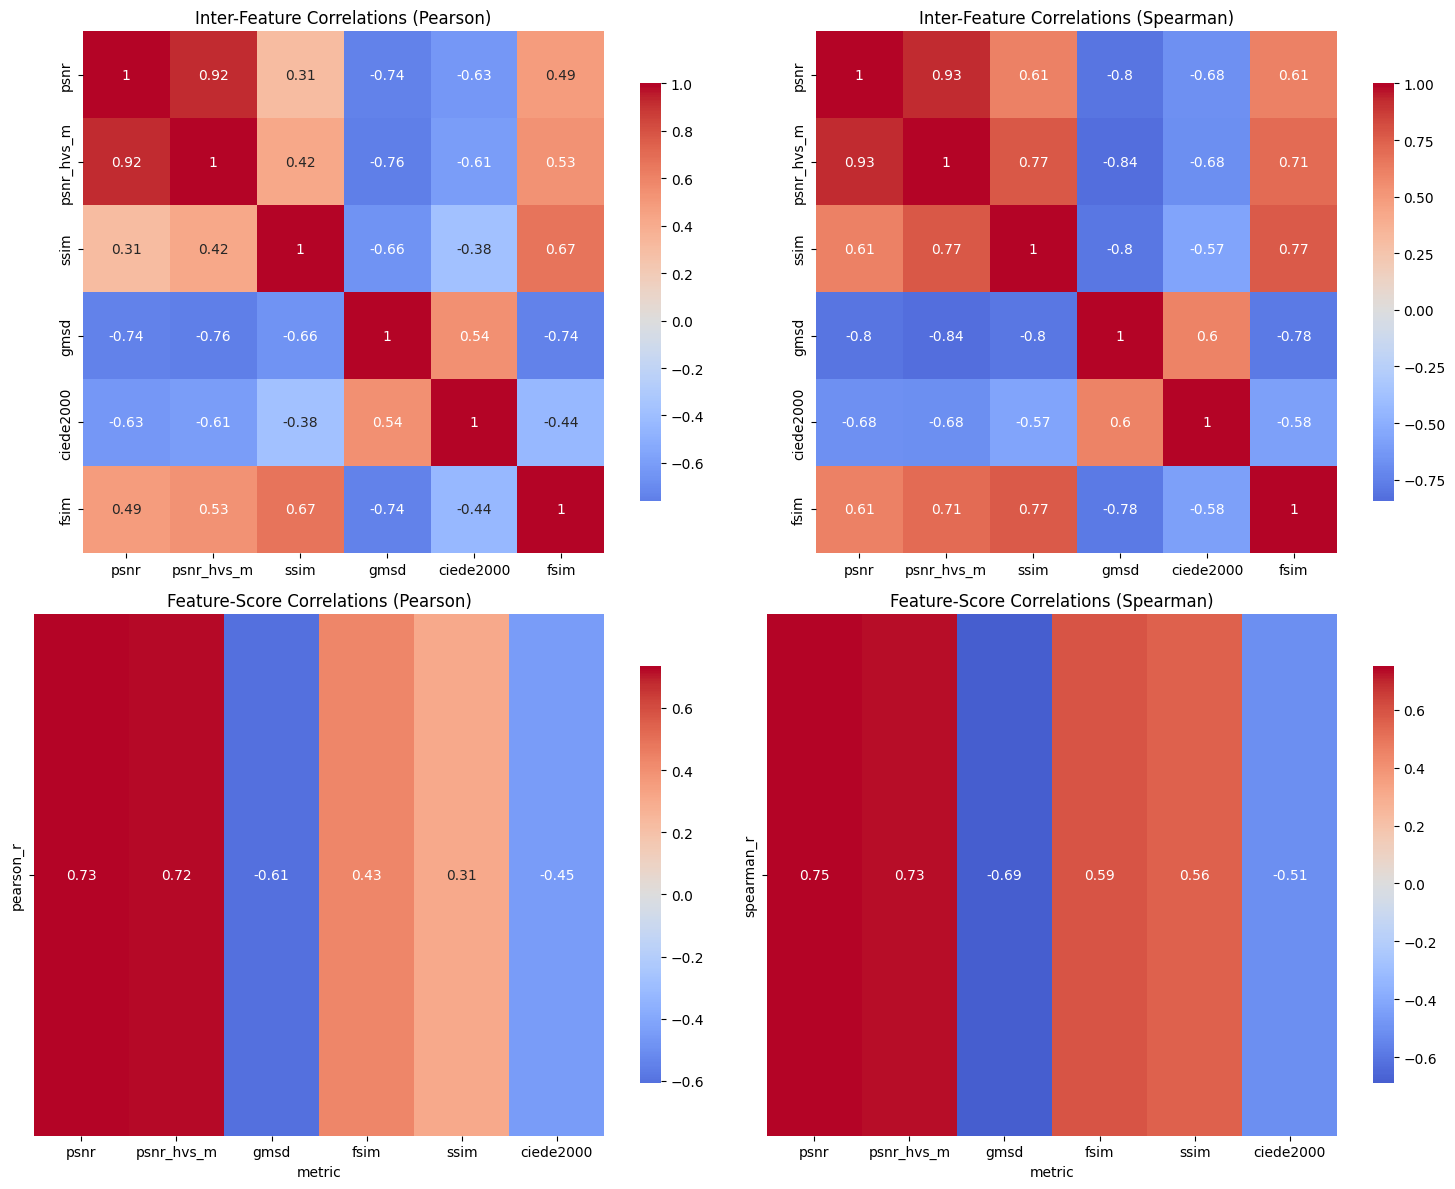


=== HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8) ===
  feature_1   feature_2  correlation
0      psnr  psnr_hvs_m     0.922338

=== METRICS BY SCORE ANALYSIS ===


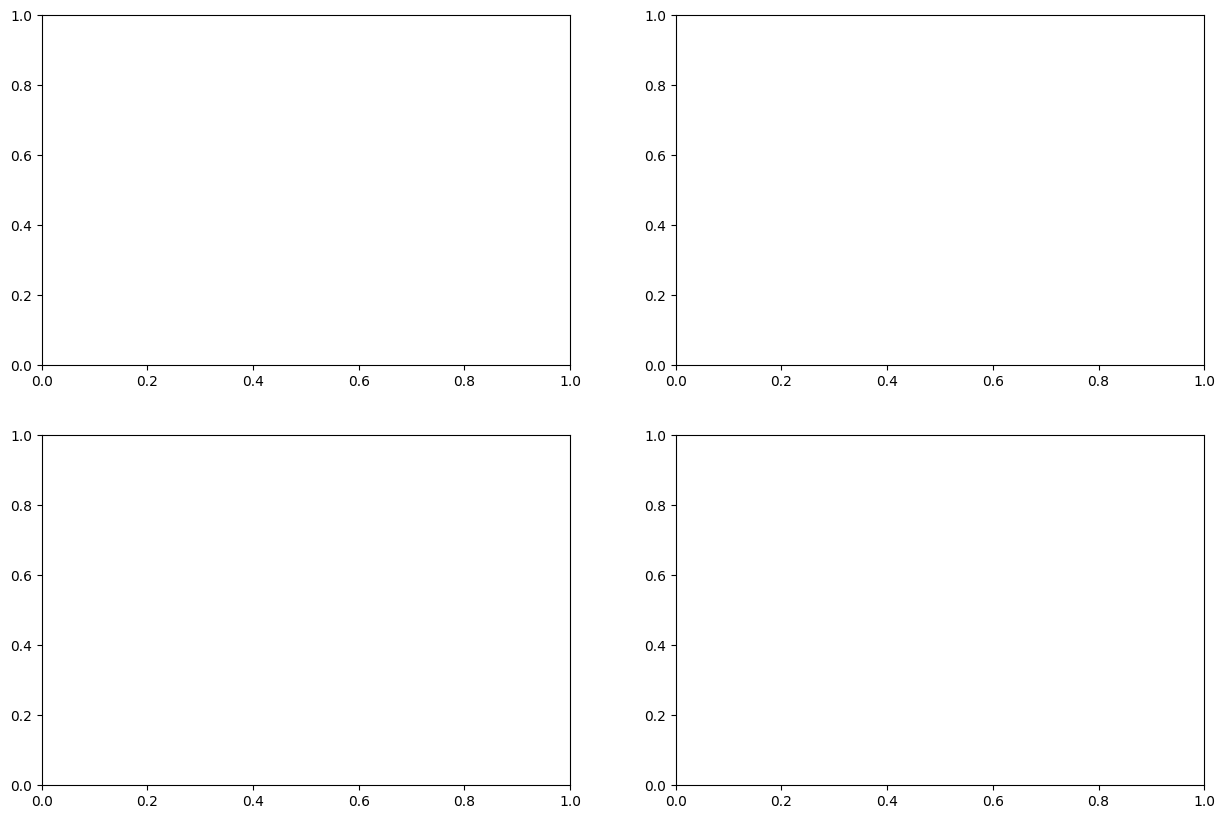

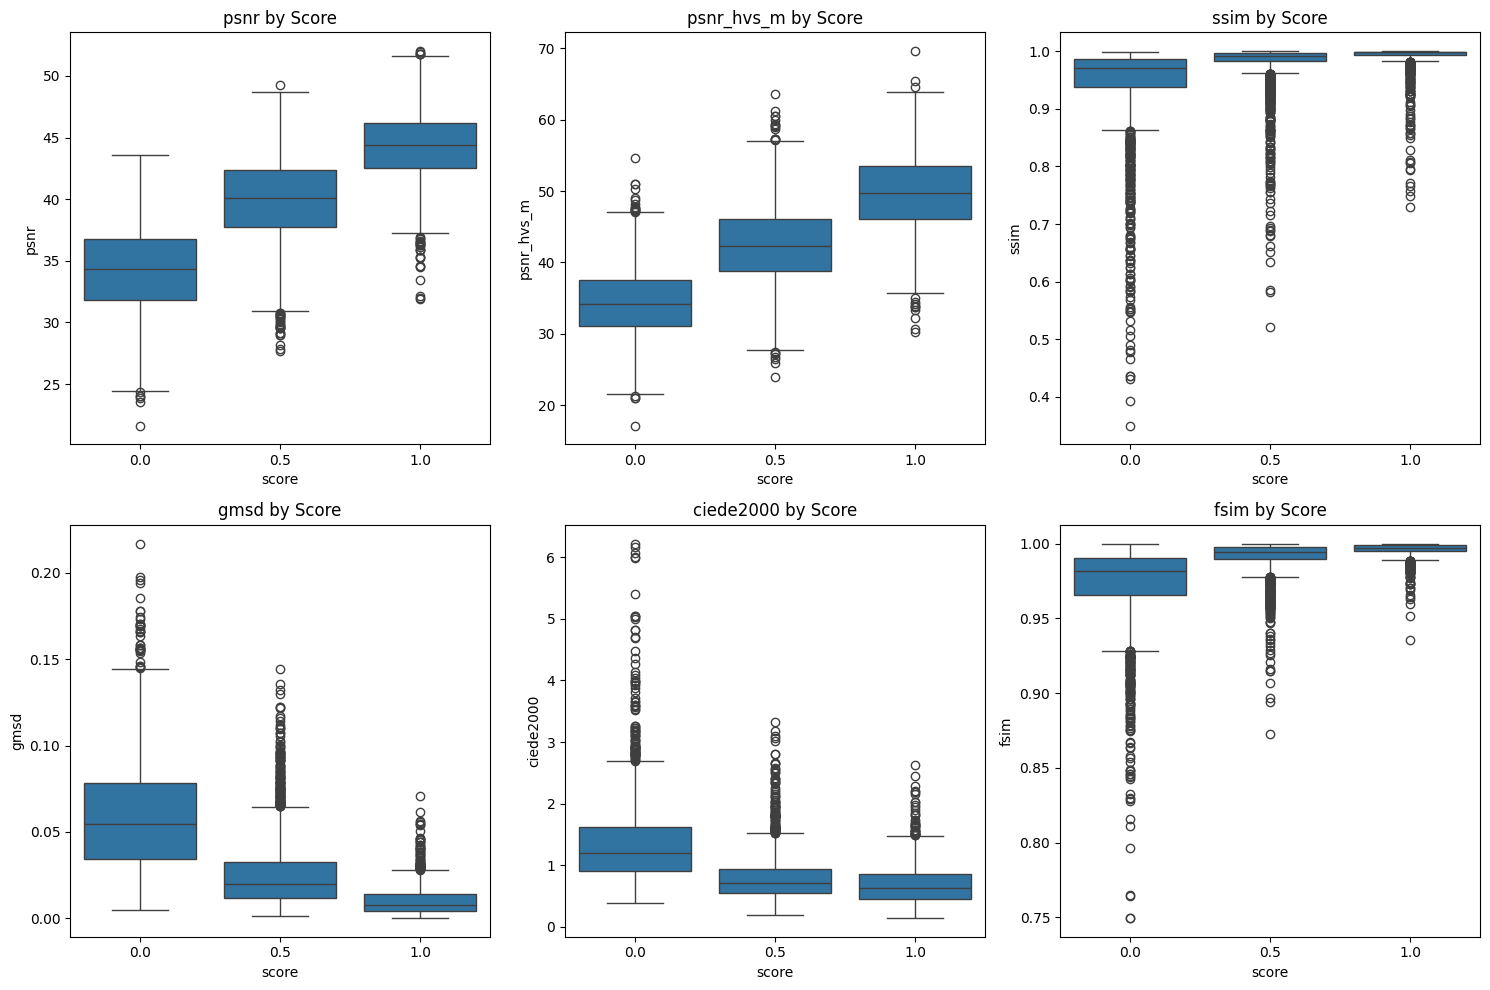


Mean values by score:
          psnr  psnr_hvs_m    ssim    gmsd  ciede2000    fsim
score                                                        
0.0    34.1995     34.4330  0.9427  0.0597     1.3501  0.9728
0.5    39.8762     42.5167  0.9808  0.0252     0.7818  0.9915
1.0    44.3146     49.7551  0.9888  0.0106     0.6927  0.9956

Standard deviation by score:
         psnr  psnr_hvs_m    ssim    gmsd  ciede2000    fsim
score                                                       
0.0    3.5200      4.9152  0.0803  0.0328     0.6945  0.0282
0.5    3.4874      5.5828  0.0382  0.0195     0.3656  0.0102
1.0    2.9883      5.5252  0.0286  0.0094     0.3417  0.0054


In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

class ImageMetricsAnalyzer:
    def __init__(self, df):
        """
        Initialize the analyzer with your dataset

        Parameters:
        df (DataFrame): Your dataset with image comparison metrics
                       Should have columns for metrics and a 'score' column with 0.0, 0.5, 1.0
        """
        self.df = df.copy()
        self.metric_columns = [col for col in df.columns if col != 'score']
        self.correlation_results = {}

    def basic_stats(self):
        """Display basic statistics about your dataset"""
        print("=== DATASET OVERVIEW ===")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Number of metrics: {len(self.metric_columns)}")
        print(f"Metric columns: {self.metric_columns}")
        print("\n=== SCORE DISTRIBUTION ===")
        print(self.df['score'].value_counts().sort_index())
        print(f"Score percentages:")
        print((self.df['score'].value_counts(normalize=True) * 100).sort_index().round(2))

        print("\n=== MISSING VALUES ===")
        missing = self.df.isnull().sum()
        if missing.sum() > 0:
            print(missing[missing > 0])
        else:
            print("No missing values found!")

        print("\n=== BASIC STATISTICS ===")
        print(self.df[self.metric_columns].describe())

    def compute_inter_feature_correlations(self):
        """Compute correlations between all metric features"""
        print("\n=== INTER-FEATURE CORRELATIONS ===")

        # Pearson correlation (linear relationships)
        pearson_corr = self.df[self.metric_columns].corr(method='pearson')

        # Spearman correlation (monotonic relationships)
        spearman_corr = self.df[self.metric_columns].corr(method='spearman')

        # Store results
        self.correlation_results['pearson'] = pearson_corr
        self.correlation_results['spearman'] = spearman_corr

        return pearson_corr, spearman_corr

    def compute_feature_score_correlations(self):
        """Compute correlations between each metric and the scores"""
        print("\n=== FEATURE-SCORE CORRELATIONS ===")

        correlations = []

        for metric in self.metric_columns:
            # Pearson correlation
            pearson_r, pearson_p = pearsonr(self.df[metric], self.df['score'])

            # Spearman correlation (better for ordinal scores like 0, 0.5, 1)
            spearman_r, spearman_p = spearmanr(self.df[metric], self.df['score'])

            correlations.append({
                'metric': metric,
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p
            })

        correlation_df = pd.DataFrame(correlations)
        correlation_df = correlation_df.sort_values('spearman_r', key=abs, ascending=False)

        print("Correlations with scores (sorted by absolute Spearman correlation):")
        print(correlation_df.round(4))

        return correlation_df

    def plot_correlation_heatmaps(self, figsize=(15, 12)):
        """Create correlation heatmaps"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Inter-feature Pearson correlation
        sns.heatmap(self.correlation_results['pearson'],
                   annot=True, cmap='coolwarm', center=0,
                   square=True, ax=axes[0,0], cbar_kws={'shrink': 0.8})
        axes[0,0].set_title('Inter-Feature Correlations (Pearson)')

        # Inter-feature Spearman correlation
        sns.heatmap(self.correlation_results['spearman'],
                   annot=True, cmap='coolwarm', center=0,
                   square=True, ax=axes[0,1], cbar_kws={'shrink': 0.8})
        axes[0,1].set_title('Inter-Feature Correlations (Spearman)')

        # Feature-score correlations
        feature_score_corr = self.compute_feature_score_correlations()

        # Pearson with scores
        pearson_scores = feature_score_corr.set_index('metric')[['pearson_r']]
        sns.heatmap(pearson_scores.T, annot=True, cmap='coolwarm', center=0,
                   ax=axes[1,0], cbar_kws={'shrink': 0.8})
        axes[1,0].set_title('Feature-Score Correlations (Pearson)')

        # Spearman with scores
        spearman_scores = feature_score_corr.set_index('metric')[['spearman_r']]
        sns.heatmap(spearman_scores.T, annot=True, cmap='coolwarm', center=0,
                   ax=axes[1,1], cbar_kws={'shrink': 0.8})
        axes[1,1].set_title('Feature-Score Correlations (Spearman)')

        plt.tight_layout()
        plt.show()

        return feature_score_corr

    def find_highly_correlated_features(self, threshold=0.8):
        """Find pairs of features that are highly correlated"""
        print(f"\n=== HIGHLY CORRELATED FEATURE PAIRS (|r| > {threshold}) ===")

        pearson_corr = self.correlation_results['pearson']

        # Get upper triangle of correlation matrix
        mask = np.triu(np.ones_like(pearson_corr, dtype=bool), k=1)
        high_corr_pairs = []

        for i in range(len(pearson_corr.columns)):
            for j in range(i+1, len(pearson_corr.columns)):
                corr_val = pearson_corr.iloc[i, j]
                if abs(corr_val) > threshold:
                    high_corr_pairs.append({
                        'feature_1': pearson_corr.columns[i],
                        'feature_2': pearson_corr.columns[j],
                        'correlation': corr_val
                    })

        if high_corr_pairs:
            high_corr_df = pd.DataFrame(high_corr_pairs)
            high_corr_df = high_corr_df.sort_values('correlation', key=abs, ascending=False)
            print(high_corr_df)
            return high_corr_df
        else:
            print("No highly correlated feature pairs found.")
            return pd.DataFrame()

    def analyze_metrics_by_score(self):
        """Analyze how metrics vary by score"""
        print("\n=== METRICS BY SCORE ANALYSIS ===")

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Box plots for each metric by score
        n_metrics = len(self.metric_columns)
        n_cols = 3
        n_rows = (n_metrics + n_cols - 1) // n_cols

        fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes2 = axes2.flatten() if n_rows > 1 else [axes2] if n_cols == 1 else axes2

        for i, metric in enumerate(self.metric_columns):
            if i < len(axes2):
                sns.boxplot(data=self.df, x='score', y=metric, ax=axes2[i])
                axes2[i].set_title(f'{metric} by Score')

        # Hide unused subplots
        for i in range(len(self.metric_columns), len(axes2)):
            axes2[i].set_visible(False)

        plt.tight_layout()
        plt.show()

        # Statistical summary by score
        print("\nMean values by score:")
        print(self.df.groupby('score')[self.metric_columns].mean().round(4))

        print("\nStandard deviation by score:")
        print(self.df.groupby('score')[self.metric_columns].std().round(4))

    def full_analysis(self):
        """Run complete correlation analysis"""
        self.basic_stats()
        self.compute_inter_feature_correlations()
        feature_score_corr = self.plot_correlation_heatmaps()
        self.find_highly_correlated_features()
        self.analyze_metrics_by_score()

        return {
            'inter_feature_correlations': self.correlation_results,
            'feature_score_correlations': feature_score_corr
        }

# <--- USING THE CLASS --->

# Load your dataset (should have 'score' column now)
df = features_df.reset_index(level=0).drop(['clean_image', 'method'], axis=1)

# Run analysis
analyzer = ImageMetricsAnalyzer(df)
results = analyzer.full_analysis()

# Regression

In [375]:
features_df.head(6)

method  score       psnr      ssim      fsim
clean_image distorted_image                                             
4547604     4547601            new    0.0  29.502193  0.929600  0.941267
            4547602            ref    0.5  36.386263  0.986010  0.980178
            45476015           new    0.5  35.534318  0.981783  0.975761
4547612     4547609            new    0.0  33.694425  0.913492  0.959974
            4547610            ref    0.5  40.226299  0.963462  0.986399
            45476095           new    0.5  39.714403  0.977876  0.988621

## Make X and y, Split train and test

In [11]:
X = features_df.reset_index(level=0).drop(['clean_image', 'method', 'score'], axis=1)
y = features_df.reset_index(level=0)['score']

In [12]:
train_df = pd.read_json(train_path)
test_df = pd.read_json(test_path)

train_index = train_df.distorted_image.astype(str)
test_index = test_df.distorted_image.astype(str)

In [13]:
X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

In [14]:
blended_images = dataset_metadata[
    dataset_metadata['unique_sample_id'].str.contains('blended')
    ]['distorted_image'].values.astype(str)


# Find the intersection of X_train index and blended_images
X_train_original_indices = X_train.index.difference(blended_images)
X_test_original_indices = X_test.index.difference(blended_images)
y_train_original_indices = y_train.index.difference(blended_images)
y_test_original_indices = y_test.index.difference(blended_images)

# Select the rows from X_train using the intersecting indices
X_train = X_train.loc[X_train_original_indices]
X_test = X_test.loc[X_test_original_indices]
y_train = y_train.loc[y_train_original_indices]
y_test = y_test.loc[y_test_original_indices]


## Version 1

In [102]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

class ImageQualityRegressor:
    """Train and evaluate different regression models for image quality assessment.
    Version 1"""

    def __init__(self):
        self.models = {}
        self.results = {}
        self.best_model = None
        self.scaler = StandardScaler()

    def setup_models(self):
        """Define different regression models to try"""
        self.models = {
            # Linear models
            'Linear': LinearRegression(),
            'Ridge': Ridge(alpha=1.0),
            'Lasso': Lasso(alpha=0.1),
            'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),

            # Polynomial regression
            'Polynomial_2': Pipeline([
                ('poly', PolynomialFeatures(degree=2)),
                ('linear', LinearRegression())
            ]),

            # Tree-based models
            'DecisionTree': DecisionTreeRegressor(random_state=42),
            'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
            'GradientBoosting': GradientBoostingRegressor(random_state=42),

            # Other models
            'SVR_linear': SVR(kernel='linear'),
            'SVR_rbf': SVR(kernel='rbf'),
            'KNN': KNeighborsRegressor(n_neighbors=5),
        }

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        """Train all models and evaluate performance"""

        # Scale features for models that benefit from it
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.setup_models()
        results = []

        for name, model in self.models.items():
            print(f"Training {name}...")

            # Choose scaled or unscaled features based on model type
            if name in ['SVR_linear', 'SVR_rbf', 'KNN', 'Ridge', 'Lasso', 'ElasticNet']:
                X_tr, X_te = X_train_scaled, X_test_scaled
            else:
                X_tr, X_te = X_train, X_test

            # Train model
            model.fit(X_tr, y_train)

            # Predictions
            y_train_pred = model.predict(X_tr)
            y_test_pred = model.predict(X_te)

            # Metrics
            train_mse = mean_squared_error(y_train, y_train_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)
            train_mae = mean_absolute_error(y_train, y_train_pred)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)

            # Correlations
            train_corr_p, _ = pearsonr(y_train, y_train_pred)
            test_corr_p, _ = pearsonr(y_test, y_test_pred)
            train_corr_s, _ = spearmanr(y_train, y_train_pred)
            test_corr_s, _ = spearmanr(y_test, y_test_pred)

            # Cross-validation score
            cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='neg_mean_squared_error')
            cv_mse = -cv_scores.mean()
            cv_std = cv_scores.std()

            result = {
                'Model': name,
                'Train_MSE': train_mse,
                'Test_MSE': test_mse,
                'Train_MAE': train_mae,
                'Test_MAE': test_mae,
                'Train_R2': train_r2,
                'Test_R2': test_r2,
                'Train_Pearson': train_corr_p,
                'Test_Pearson': test_corr_p,
                'Train_Spearman': train_corr_s,
                'Test_Spearman': test_corr_s,
                'CV_MSE': cv_mse,
                'CV_Std': cv_std,
                'Overfitting': train_mse - test_mse  # Negative means better test performance
            }

            results.append(result)
            self.results[name] = {
                'model': model,
                'y_train_pred': y_train_pred,
                'y_test_pred': y_test_pred,
                'metrics': result
            }

        # Convert to DataFrame for easy analysis
        self.results_df = pd.DataFrame(results)

        # Find best model based on test MSE
        best_idx = self.results_df['Test_MSE'].idxmin()
        self.best_model_name = self.results_df.iloc[best_idx]['Model']
        self.best_model = self.results[self.best_model_name]['model']

        print(f"\nBest model: {self.best_model_name}")
        print(f"Test MSE: {self.results_df.iloc[best_idx]['Test_MSE']:.4f}")

        return self.results_df

    def print_results_summary(self):
        """Print formatted results summary"""
        df = self.results_df.copy()

        # Sort by test MSE
        df = df.sort_values('Test_MSE')

        print("\n" + "="*80)
        print("MODEL PERFORMANCE SUMMARY")
        print("="*80)

        print(f"{'Model':<15} {'Test MSE':<10} {'Test MAE':<10} {'Test R²':<10} {'Test Corr':<12} {'CV MSE':<10}")
        print("-"*80)

        for _, row in df.iterrows():
            print(f"{row['Model']:<15} {row['Test_MSE']:<10.4f} {row['Test_MAE']:<10.4f} "
                  f"{row['Test_R2']:<10.4f} {row['Test_Pearson']:<12.4f} {row['CV_MSE']:<10.4f}")

    def plot_results(self, figsize=(15, 10)):
        """Create comprehensive visualization of results"""
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Model Performance Comparison', fontsize=16)

        df = self.results_df.sort_values('Test_MSE')

        # 1. Test MSE comparison
        axes[0,0].barh(df['Model'], df['Test_MSE'])
        axes[0,0].set_title('Test MSE (Lower is Better)')
        axes[0,0].set_xlabel('MSE')

        # 2. Test R² comparison
        axes[0,1].barh(df['Model'], df['Test_R2'])
        axes[0,1].set_title('Test R² (Higher is Better)')
        axes[0,1].set_xlabel('R²')

        # 3. Test vs Train MSE (overfitting check)
        x = np.arange(len(df))
        width = 0.35
        axes[0,2].bar(x - width/2, df['Train_MSE'], width, label='Train MSE', alpha=0.7)
        axes[0,2].bar(x + width/2, df['Test_MSE'], width, label='Test MSE', alpha=0.7)
        axes[0,2].set_title('Train vs Test MSE')
        axes[0,2].set_xlabel('Models')
        axes[0,2].set_ylabel('MSE')
        axes[0,2].set_xticks(x)
        axes[0,2].set_xticklabels(df['Model'], rotation=45)
        axes[0,2].legend()

        # 4. Cross-validation scores with error bars
        axes[1,0].errorbar(range(len(df)), df['CV_MSE'], yerr=df['CV_Std'],
                          fmt='o', capsize=5)
        axes[1,0].set_title('Cross-Validation MSE with Std Dev')
        axes[1,0].set_xlabel('Models')
        axes[1,0].set_ylabel('CV MSE')
        axes[1,0].set_xticks(range(len(df)))
        axes[1,0].set_xticklabels(df['Model'], rotation=45)

        # 5. Correlation comparison
        axes[1,1].scatter(df['Test_Pearson'], df['Test_Spearman'], s=100)
        for i, model in enumerate(df['Model']):
            axes[1,1].annotate(model, (df['Test_Pearson'].iloc[i], df['Test_Spearman'].iloc[i]),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
        axes[1,1].set_xlabel('Pearson Correlation')
        axes[1,1].set_ylabel('Spearman Correlation')
        axes[1,1].set_title('Correlation Comparison')
        axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)

        # 6. Prediction scatter plot for best model
        best_results = self.results[self.best_model_name]
        y_test_true = None  # You'll need to pass this
        y_test_pred = best_results['y_test_pred']

        # This plot needs actual y_test values - placeholder for now
        axes[1,2].text(0.5, 0.5, f'Best Model: {self.best_model_name}\n'
                                  f'Test MSE: {df.iloc[0]["Test_MSE"]:.4f}\n'
                                  f'Test R²: {df.iloc[0]["Test_R2"]:.4f}',
                      ha='center', va='center', transform=axes[1,2].transAxes,
                      fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        axes[1,2].set_title('Best Model Summary')
        axes[1,2].axis('off')

        plt.tight_layout()
        plt.show()

    def plot_predictions_vs_actual(self, y_test, model_name=None):
        """Plot predictions vs actual values for a specific model"""
        if model_name is None:
            model_name = self.best_model_name

        y_pred = self.results[model_name]['y_test_pred']

        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Scores')
        plt.ylabel('Predicted Scores')
        plt.title(f'Predictions vs Actual - {model_name}')

        # Add metrics to plot
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        plt.text(0.05, 0.95, f'MSE: {mse:.4f}\nR²: {r2:.4f}',
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

        plt.grid(True, alpha=0.3)
        plt.show()

    def hyperparameter_tuning(self, X_train, y_train, model_names=['RandomForest', 'GradientBoosting', 'SVR_rbf']):
        """Perform hyperparameter tuning for selected models"""

        param_grids = {
            'RandomForest': {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7, None],
                'min_samples_split': [2, 5, 10]
            },
            'GradientBoosting': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            },
            'SVR_rbf': {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
            }
        }

        tuned_models = {}

        for model_name in model_names:
            if model_name not in self.models:
                continue

            print(f"Tuning {model_name}...")

            # Use scaled features for SVR
            if model_name.startswith('SVR'):
                X_train_use = self.scaler.fit_transform(X_train)
            else:
                X_train_use = X_train

            grid_search = GridSearchCV(
                self.models[model_name],
                param_grids[model_name],
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )

            grid_search.fit(X_train_use, y_train)

            tuned_models[model_name] = {
                'model': grid_search.best_estimator_,
                'best_params': grid_search.best_params_,
                'best_score': -grid_search.best_score_
            }

            print(f"Best parameters for {model_name}: {grid_search.best_params_}")
            print(f"Best CV score: {-grid_search.best_score_:.4f}")

        return tuned_models


## Version 2

In [15]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

class ImageQualityRegressor:
    """Train and evaluate different regression models for image quality assessment.
    Version 2"""

    def __init__(self):
        self.models = {}
        self.results = {}
        self.best_model = None
        self.scaler = StandardScaler()

    def setup_models(self):
        """Define different regression models to try"""
        self.models = {
            # Polynomial regression
            'Polynomial_2': Pipeline([
                ('poly', PolynomialFeatures(degree=2)),
                ('linear', LinearRegression())
            ]),

            # Tree-based models
            'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
            'GradientBoosting': GradientBoostingRegressor(random_state=42),

            # SVR model
            'SVR_rbf': SVR(kernel='rbf'),
        }

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        """Train all models and evaluate performance"""

        # Scale features for models that benefit from it
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.setup_models()
        results = []

        for name, model in self.models.items():
            print(f"Training {name}...")

            # Choose scaled or unscaled features based on model type
            if name in ['SVR_rbf']:
                X_tr, X_te = X_train_scaled, X_test_scaled
            else:
                X_tr, X_te = X_train, X_test

            # Train model
            model.fit(X_tr, y_train)

            # Predictions
            y_train_pred = model.predict(X_tr)
            y_test_pred = model.predict(X_te)

            # Metrics
            train_mse = mean_squared_error(y_train, y_train_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)
            train_mae = mean_absolute_error(y_train, y_train_pred)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)

            # Correlations
            train_corr_p, _ = pearsonr(y_train, y_train_pred)
            test_corr_p, _ = pearsonr(y_test, y_test_pred)
            train_corr_s, _ = spearmanr(y_train, y_train_pred)
            test_corr_s, _ = spearmanr(y_test, y_test_pred)

            # Cross-validation score
            cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='neg_mean_squared_error')
            cv_mse = -cv_scores.mean()
            cv_std = cv_scores.std()

            result = {
                'Model': name,
                'Train_MSE': train_mse,
                'Test_MSE': test_mse,
                'Train_MAE': train_mae,
                'Test_MAE': test_mae,
                'Train_R2': train_r2,
                'Test_R2': test_r2,
                'Train_Pearson': train_corr_p,
                'Test_Pearson': test_corr_p,
                'Train_Spearman': train_corr_s,
                'Test_Spearman': test_corr_s,
                'CV_MSE': cv_mse,
                'CV_Std': cv_std,
                'Overfitting': train_mse - test_mse  # Negative means better test performance
            }

            results.append(result)
            self.results[name] = {
                'model': model,
                'y_train_pred': y_train_pred,
                'y_test_pred': y_test_pred,
                'metrics': result
            }

        # Convert to DataFrame for easy analysis
        self.results_df = pd.DataFrame(results)

        # Find best model based on test MSE
        best_idx = self.results_df['Test_MSE'].idxmin()
        self.best_model_name = self.results_df.iloc[best_idx]['Model']
        self.best_model = self.results[self.best_model_name]['model']

        print(f"\nBest model: {self.best_model_name}")
        print(f"Test MSE: {self.results_df.iloc[best_idx]['Test_MSE']:.4f}")

        return self.results_df

    def print_results_summary(self):
        """Print formatted results summary"""
        df = self.results_df.copy()

        # Sort by test MSE
        df = df.sort_values('Test_MSE')

        print("\n" + "="*80)
        print("MODEL PERFORMANCE SUMMARY")
        print("="*80)

        print(f"{'Model':<15} {'Test MSE':<10} {'Test MAE':<10} {'Test R²':<10} {'Test Corr':<12} {'CV MSE':<10}")
        print("-"*80)

        for _, row in df.iterrows():
            print(f"{row['Model']:<15} {row['Test_MSE']:<10.4f} {row['Test_MAE']:<10.4f} "
                  f"{row['Test_R2']:<10.4f} {row['Test_Pearson']:<12.4f} {row['CV_MSE']:<10.4f}")

    def plot_results(self, figsize=(15, 10)):
        """Create comprehensive visualization of results"""
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Model Performance Comparison', fontsize=16)

        df = self.results_df.sort_values('Test_MSE')

        # 1. Test MSE comparison
        axes[0,0].barh(df['Model'], df['Test_MSE'])
        axes[0,0].set_title('Test MSE (Lower is Better)')
        axes[0,0].set_xlabel('MSE')

        # 2. Test R² comparison
        axes[0,1].barh(df['Model'], df['Test_R2'])
        axes[0,1].set_title('Test R² (Higher is Better)')
        axes[0,1].set_xlabel('R²')

        # 3. Test vs Train MSE (overfitting check)
        x = np.arange(len(df))
        width = 0.35
        axes[0,2].bar(x - width/2, df['Train_MSE'], width, label='Train MSE', alpha=0.7)
        axes[0,2].bar(x + width/2, df['Test_MSE'], width, label='Test MSE', alpha=0.7)
        axes[0,2].set_title('Train vs Test MSE')
        axes[0,2].set_xlabel('Models')
        axes[0,2].set_ylabel('MSE')
        axes[0,2].set_xticks(x)
        axes[0,2].set_xticklabels(df['Model'], rotation=45)
        axes[0,2].legend()

        # 4. Cross-validation scores with error bars
        axes[1,0].errorbar(range(len(df)), df['CV_MSE'], yerr=df['CV_Std'],
                          fmt='o', capsize=5)
        axes[1,0].set_title('Cross-Validation MSE with Std Dev')
        axes[1,0].set_xlabel('Models')
        axes[1,0].set_ylabel('CV MSE')
        axes[1,0].set_xticks(range(len(df)))
        axes[1,0].set_xticklabels(df['Model'], rotation=45)

        # 5. Correlation comparison
        axes[1,1].scatter(df['Test_Pearson'], df['Test_Spearman'], s=100)
        for i, model in enumerate(df['Model']):
            axes[1,1].annotate(model, (df['Test_Pearson'].iloc[i], df['Test_Spearman'].iloc[i]),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
        axes[1,1].set_xlabel('Pearson Correlation')
        axes[1,1].set_ylabel('Spearman Correlation')
        axes[1,1].set_title('Correlation Comparison')
        axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)

        # 6. Prediction scatter plot for best model
        best_results = self.results[self.best_model_name]
        y_test_true = None  # You'll need to pass this
        y_test_pred = best_results['y_test_pred']

        # This plot needs actual y_test values - placeholder for now
        axes[1,2].text(0.5, 0.5, f'Best Model: {self.best_model_name}\n'
                                  f'Test MSE: {df.iloc[0]["Test_MSE"]:.4f}\n'
                                  f'Test R²: {df.iloc[0]["Test_R2"]:.4f}',
                      ha='center', va='center', transform=axes[1,2].transAxes,
                      fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        axes[1,2].set_title('Best Model Summary')
        axes[1,2].axis('off')

        plt.tight_layout()
        plt.show()

    def plot_predictions_vs_actual(self, y_test, model_name=None):
        """Plot predictions vs actual values for a specific model"""
        if model_name is None:
            model_name = self.best_model_name

        y_pred = self.results[model_name]['y_test_pred']

        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Scores')
        plt.ylabel('Predicted Scores')
        plt.title(f'Predictions vs Actual - {model_name}')

        # Add metrics to plot
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        plt.text(0.05, 0.95, f'MSE: {mse:.4f}\nR²: {r2:.4f}',
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

        plt.grid(True, alpha=0.3)
        plt.show()

    def hyperparameter_tuning(self, X_train, y_train, model_names=['RandomForest', 'GradientBoosting', 'SVR_rbf']):
        """Perform hyperparameter tuning for selected models"""

        param_grids = {
            'RandomForest': {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7, None],
                'min_samples_split': [2, 5, 10]
            },
            'GradientBoosting': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            },
            'SVR_rbf': {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
            }
        }

        tuned_models = {}

        for model_name in model_names:
            if model_name not in self.models:
                continue

            print(f"Tuning {model_name}...")

            # Use scaled features for SVR
            if model_name.startswith('SVR'):
                X_train_use = self.scaler.fit_transform(X_train)
            else:
                X_train_use = X_train

            grid_search = GridSearchCV(
                self.models[model_name],
                param_grids[model_name],
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )

            grid_search.fit(X_train_use, y_train)

            tuned_models[model_name] = {
                'model': grid_search.best_estimator_,
                'best_params': grid_search.best_params_,
                'best_score': -grid_search.best_score_
            }

            print(f"Best parameters for {model_name}: {grid_search.best_params_}")
            print(f"Best CV score: {-grid_search.best_score_:.4f}")

        return tuned_models


## Usage

Assuming you have your features extracted

X_train: (n_samples, n_features)

y_train: (n_samples,) - similarity scores

X_test, y_test: test set

Training Polynomial_2...
Training RandomForest...
Training GradientBoosting...
Training SVR_rbf...

Best model: GradientBoosting
Test MSE: 0.0491

MODEL PERFORMANCE SUMMARY
Model           Test MSE   Test MAE   Test R²    Test Corr    CV MSE    
--------------------------------------------------------------------------------
GradientBoosting 0.0491     0.1414     0.7480     0.8653       0.0477    
RandomForest    0.0510     0.1415     0.7382     0.8594       0.0504    
SVR_rbf         0.0551     0.1611     0.7169     0.8472       0.0489    
Polynomial_2    0.0642     0.1905     0.6702     0.8190       0.0615    


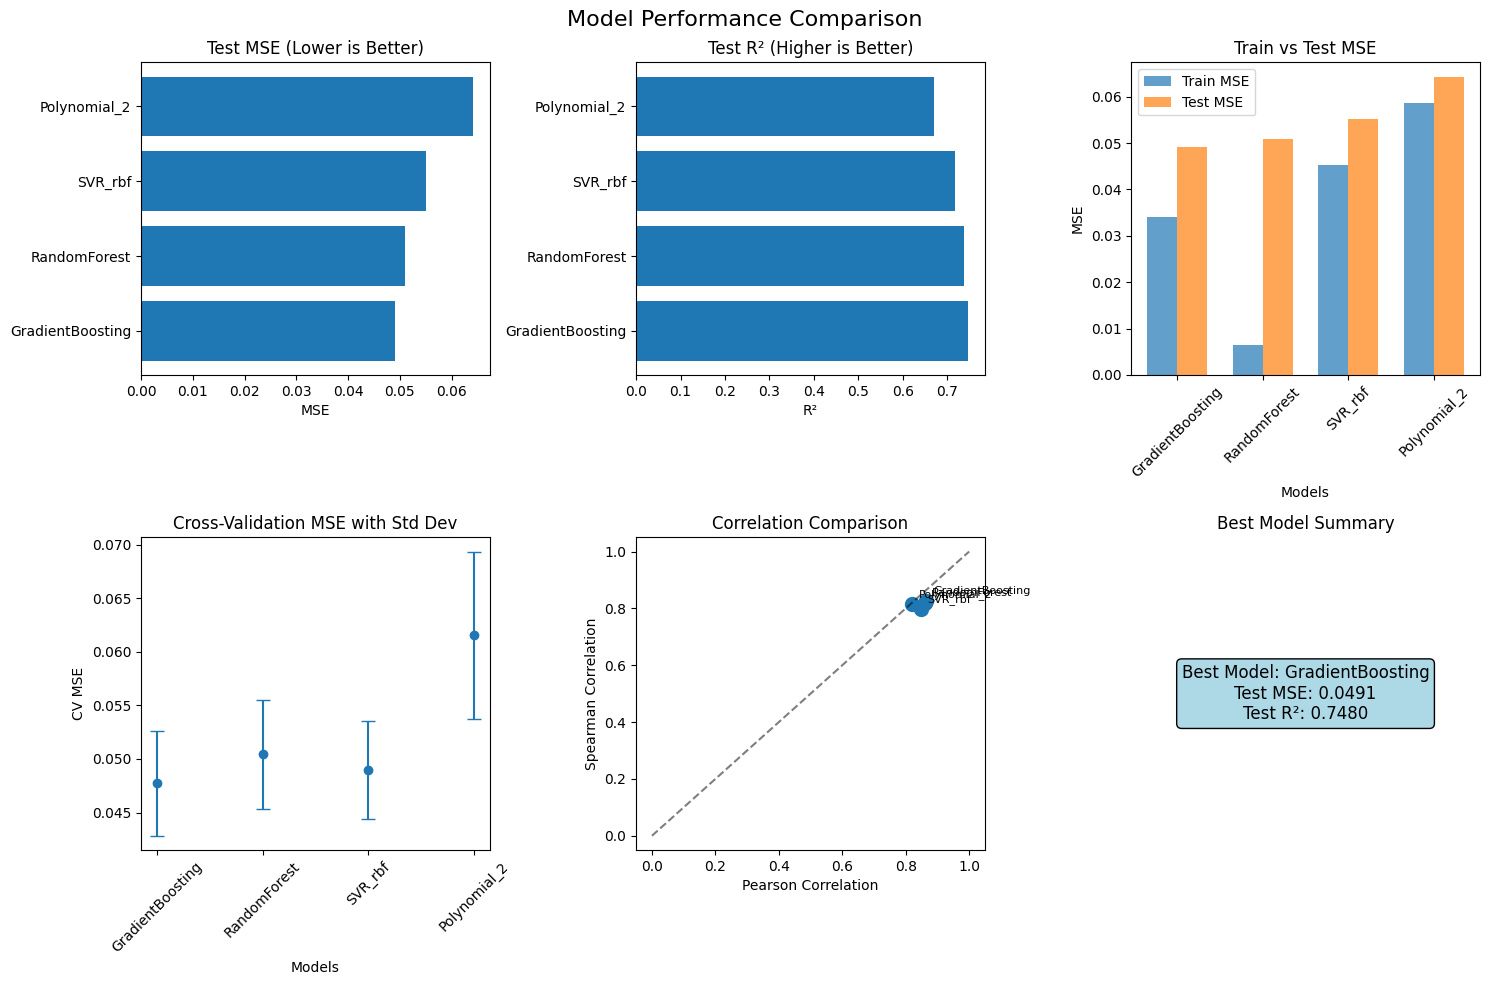

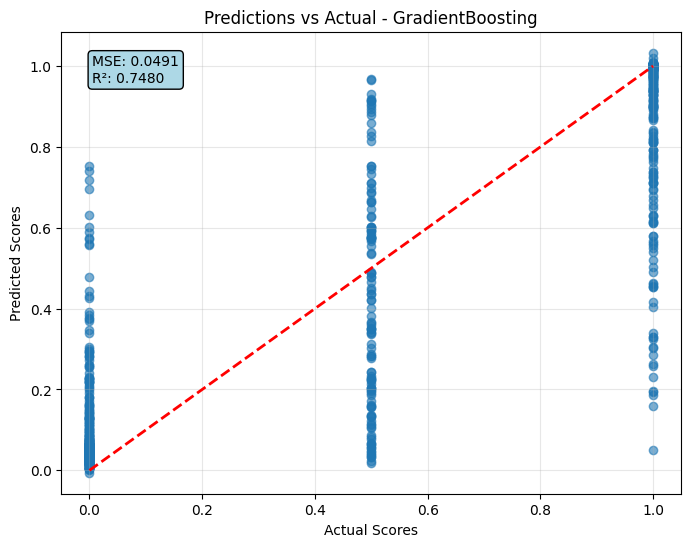

Tuning RandomForest...
Best parameters for RandomForest: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score: 0.0470
Tuning GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best CV score: 0.0472
Tuning SVR_rbf...
Best parameters for SVR_rbf: {'C': 1, 'gamma': 'scale'}
Best CV score: 0.0489


In [24]:
regressor = ImageQualityRegressor()

# Train and evaluate all models
results_df = regressor.train_and_evaluate(X_train, y_train, X_test, y_test)

# Print summary
regressor.print_results_summary()

# Plot comprehensive results
regressor.plot_results()

# Plot predictions vs actual for best model
regressor.plot_predictions_vs_actual(y_test)

# Optional: Hyperparameter tuning
tuned_models = regressor.hyperparameter_tuning(X_train, y_train)

# Evaluation

In [17]:
rf_model = regressor.results['RandomForest']['model']
gb_model = regressor.results['GradientBoosting']['model']
# Evaluate Gradient Boosting model
print("Evaluating Gradient Boosting Model:")
gb_test_mse = mean_squared_error(y_test, gb_model.predict(X_test))
gb_test_mae = mean_absolute_error(y_test, gb_model.predict(X_test))
gb_test_r2 = r2_score(y_test, gb_model.predict(X_test))
gb_test_pearson, _ = pearsonr(y_test, gb_model.predict(X_test))
gb_test_spearman, _ = spearmanr(y_test, gb_model.predict(X_test))

print(f"  Test MSE: {gb_test_mse:.4f}")
print(f"  Test MAE: {gb_test_mae:.4f}")
print(f"  Test R²: {gb_test_r2:.4f}")
print(f"  Test Pearson Correlation: {gb_test_pearson:.4f}")
print(f"  Test Spearman Correlation: {gb_test_spearman:.4f}")
print("-" * 30)

# Evaluate Random Forest model
print("Evaluating Random Forest Model:")
rf_test_mse = mean_squared_error(y_test, rf_model.predict(X_test))
rf_test_mae = mean_absolute_error(y_test, rf_model.predict(X_test))
rf_test_r2 = r2_score(y_test, rf_model.predict(X_test))
rf_test_pearson, _ = pearsonr(y_test, rf_model.predict(X_test))
rf_test_spearman, _ = spearmanr(y_test, rf_model.predict(X_test))

print(f"  Test MSE: {rf_test_mse:.4f}")
print(f"  Test MAE: {rf_test_mae:.4f}")
print(f"  Test R²: {rf_test_r2:.4f}")
print(f"  Test Pearson Correlation: {rf_test_pearson:.4f}")
print(f"  Test Spearman Correlation: {rf_test_spearman:.4f}")

Evaluating Gradient Boosting Model:
  Test MSE: 0.0491
  Test MAE: 0.1414
  Test R²: 0.7480
  Test Pearson Correlation: 0.8653
  Test Spearman Correlation: 0.8247
------------------------------
Evaluating Random Forest Model:
  Test MSE: 0.0510
  Test MAE: 0.1415
  Test R²: 0.7382
  Test Pearson Correlation: 0.8594
  Test Spearman Correlation: 0.8206


## Digitize Prediction
Digitize the score predictions from the `gb_model` and `rf_model` using the bins [0-0.33, 0.33-0.66, 0.66-1.0] mapping to values [0, 0.5, 1]. Then, create and display a confusion matrix for each model comparing the true test scores (`y_test`) to the digitized predictions.

### Define digitization function

### Subtask:
Create a Python function that takes a continuous score and maps it to one of the three discrete bins (0, 0.5, 1).


**Reasoning**:
The subtask requires defining a function to digitize continuous scores into three discrete bins. This can be achieved with a Python function using conditional statements.



In [18]:
def digitize_score(score):
    """
    Digitizes a continuous score into one of three bins: 0, 0.5, or 1.

    Args:
        score (float): The continuous score to digitize.

    Returns:
        float: The digitized score (0, 0.5, or 1).
    """
    if score <= 0.33:
        return 0
    elif 0.33 < score <= 0.66:
        return 1
    else:
        return 2

### Digitize predictions

### Subtask:
Apply the digitization function to the test predictions (`y_test_pred`) for each trained model stored in `regressor.results`.


**Reasoning**:
Access the test predictions for the Gradient Boosting model and apply the digitization function. Then, access the test predictions for the Random Forest model and apply the digitization function.



In [19]:
gb_test_pred = regressor.results['GradientBoosting']['y_test_pred']
gb_test_pred_digitized = np.array([digitize_score(score) for score in gb_test_pred])

rf_test_pred = regressor.results['RandomForest']['y_test_pred']
rf_test_pred_digitized = np.array([digitize_score(score) for score in rf_test_pred])

print("Gradient Boosting digitized predictions (first 5):", gb_test_pred_digitized[:5])
print("Random Forest digitized predictions (first 5):", rf_test_pred_digitized[:5])

Gradient Boosting digitized predictions (first 5): [0 1 2 0 1]
Random Forest digitized predictions (first 5): [0 2 2 0 1]


### Generate confusion matrices

### Subtask:
For each model, compute the confusion matrix comparing the true test scores (`y_test`) and the digitized test predictions.


**Reasoning**:
Compute and display the confusion matrices for both models.



In [20]:
from sklearn.metrics import confusion_matrix

# Digitized the true test scores
y_test_digitized = np.array([digitize_score(score) for score in y_test])

gb_cm = confusion_matrix(y_test_digitized, gb_test_pred_digitized)
rf_cm = confusion_matrix(y_test_digitized, rf_test_pred_digitized)

print("Confusion Matrix for Gradient Boosting Model:")
display(gb_cm)

print("\nConfusion Matrix for Random Forest Model:")
display(rf_cm)

Confusion Matrix for Gradient Boosting Model:


array([[367,  18,   4],
       [ 53,  46,  28],
       [ 13,  28, 183]])


Confusion Matrix for Random Forest Model:


array([[362,  25,   2],
       [ 48,  50,  29],
       [ 12,  33, 179]])

### Visualize confusion matrices

### Subtask:
Display the confusion matrices as heatmaps using `seaborn`.

**Reasoning**:
Visualize the confusion matrices using heatmaps for better readability and interpretation.

,count
score,
0.0,389
1.0,224
0.5,127


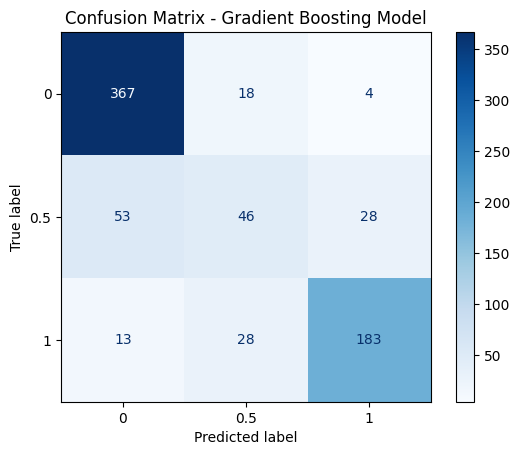

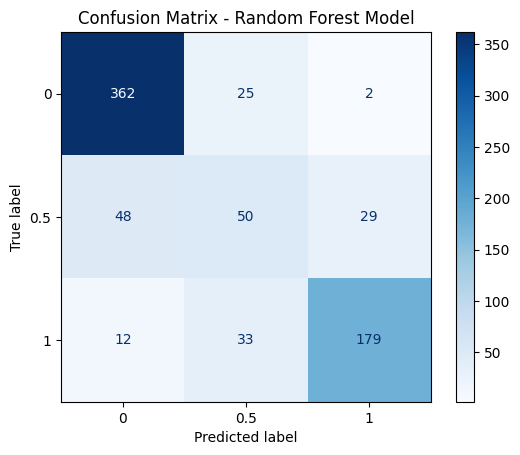

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Function to plot confusion matrix heatmap
def plot_confusion_matrix(cm, title, classes=[0, 0.5, 1]):
    """Plots a confusion matrix as a heatmap."""
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    # Use plot method which handles annotations
    disp.plot(cmap=plt.cm.Blues, values_format='d') # values_format='d' for integer counts
    plt.title(title)
    plt.show()

display(y_test.value_counts())

# Plot confusion matrix for Gradient Boosting model
plot_confusion_matrix(gb_cm, "Confusion Matrix - Gradient Boosting Model", classes=[0, 0.5, 1])

# Plot confusion matrix for Random Forest model
plot_confusion_matrix(rf_cm, "Confusion Matrix - Random Forest Model", classes=[0, 0.5, 1])

In [23]:
import numpy as np

def find_best_boundaries(preds, labels):
    """
    preds: 1D numpy array of predictions in [0,1]
    labels: 1D numpy array of true labels {0,1,2}
    Returns: (best_b1, best_b2, best_acc)
    """

    # Sort predictions and make candidate cutpoints
    sorted_preds = np.sort(preds)
    candidates = (sorted_preds[:-1] + sorted_preds[1:]) / 2.0
    candidates = np.unique(candidates)  # remove duplicates

    best_acc = -1
    best_b1, best_b2 = None, None

    # Try all pairs (b1, b2)
    for i, b1 in enumerate(candidates):
        for b2 in candidates[i+1:]:
            # Digitize predictions based on (b1, b2)
            digitized = np.digitize(preds, bins=[b1, b2])

            # Compute accuracy
            acc = (digitized == labels).mean()

            if acc > best_acc:
                best_acc = acc
                best_b1, best_b2 = b1, b2

    return best_b1, best_b2, best_acc


# Example usage:
if __name__ == "__main__":
    preds = gb_test_pred
    labels = [int(2 * score) for score in y_test]

    b1, b2, acc = find_best_boundaries(preds, labels)
    print(f"Best boundaries: b1={b1:.3f}, b2={b2:.3f}, Accuracy={acc:.3f}")


Best boundaries: b1=0.302, b2=0.607, Accuracy=0.815


## Interactive Digitization
Create a slider widget with 3 sliders to dynamically change the bin limits for digitizing scores and re-render the confusion matrix based on the new bins.

### Import necessary libraries

### Subtask:
Import necessary libraries for creating interactive widgets and updating the display in the notebook.


**Reasoning**:
The subtask requires importing libraries for creating interactive widgets and updating the display. I will import `ipywidgets` and `IPython.display`.



In [267]:
import ipywidgets as widgets
from IPython.display import display

### Define a plotting function for interaction

### Subtask:
Create a Python function that takes the bin limits as arguments, digitizes the true and predicted scores using these limits, and then plots the confusion matrix using the `plot_confusion_matrix_with_bins` function already defined in cell `wen8172U5gpZ`.


**Reasoning**:
Define the function `update_confusion_matrix` that takes two bin limits as input, constructs the bins, and then plots the confusion matrices for both models using the predefined plotting function.



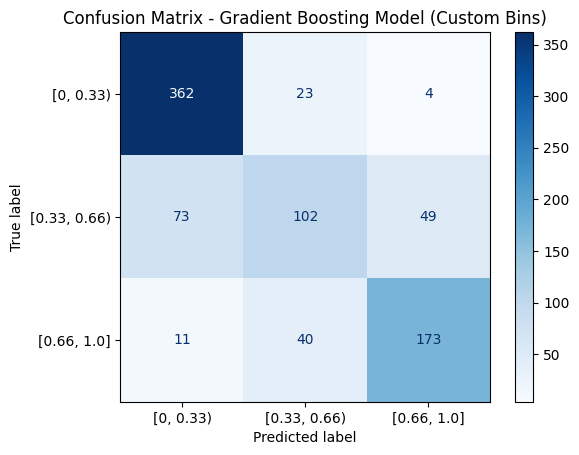

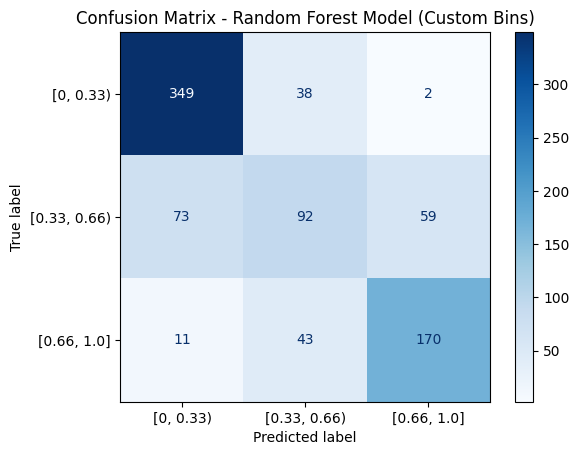

In [266]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to plot confusion matrix heatmap with customizable digitization
def plot_confusion_matrix_with_bins(y_true, y_pred, bins, title):
    """
    Plots a confusion matrix as a heatmap after digitizing scores based on provided bins.

    Args:
        y_true (array-like): True scores (continuous or discrete).
        y_pred (array-like): Predicted scores (continuous).
        bins (list): A list of bin edges (e.g., [0, 0.33, 0.66, 1.0]).
                     Scores will be digitized into len(bins)-1 categories.
        title (str): The title for the confusion matrix plot.
    """

    # Digitize scores based on bins
    def digitize(scores, bins):
        # Use np.digitize to assign scores to bins.
        # Subtract 1 because np.digitize returns bin index (1-based)
        # and we want 0-based indices for confusion matrix labels.
        # Use right=False for intervals [a, b)
        # Capping values to be within the range of bins - 1
        return np.clip(np.digitize(scores, bins, right=False) - 1, 0, len(bins) - 2)


    # Digitize true and predicted scores
    y_true_digitized = digitize(y_true, bins)
    y_pred_digitized = digitize(y_pred, bins)


    # Determine the display labels for the confusion matrix
    # These will be the bin intervals
    display_labels = []
    for i in range(len(bins) - 1):
        # Format the interval as [start, end] for the last bin
        if i == len(bins) - 2 and bins[-1] == 1.0: # Special handling for the last bin if it ends at 1.0
             display_labels.append(f'[{bins[i]}, {bins[i+1]}]')
        else: # Format other intervals as [start, end)
            display_labels.append(f'[{bins[i]}, {bins[i+1]})')


    # Compute the confusion matrix
    # The number of classes is determined by the number of bins - 1
    n_classes = len(bins) - 1
    cm = confusion_matrix(y_true_digitized, y_pred_digitized, labels=range(n_classes))

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.show()

# Example Usage with the new function:

# Define the bins for digitization
score_bins = [0, 0.33, 0.66, 1.0] # Example bins

# Get the true and predicted scores
gb_test_pred = regressor.results['GradientBoosting']['y_test_pred']
rf_test_pred = regressor.results['RandomForest']['y_test_pred']


# Plot confusion matrix for Gradient Boosting model with the specified bins
plot_confusion_matrix_with_bins(y_test, gb_test_pred, score_bins, "Confusion Matrix - Gradient Boosting Model (Custom Bins)")

# Plot confusion matrix for Random Forest Model with the specified bins
plot_confusion_matrix_with_bins(y_test, rf_test_pred, score_bins, "Confusion Matrix - Random Forest Model (Custom Bins)")

In [268]:
def update_confusion_matrix(bin_limit_1, bin_limit_2):
    """
    Updates and plots confusion matrices based on the given bin limits.

    Args:
        bin_limit_1 (float): The first bin limit (0 < bin_limit_1 < bin_limit_2).
        bin_limit_2 (float): The second bin limit (bin_limit_1 < bin_limit_2 < 1).
    """
    if not (0 < bin_limit_1 < bin_limit_2 < 1):
        print("Warning: Bin limits should be 0 < bin_limit_1 < bin_limit_2 < 1. Using default bins.")
        score_bins = [0, 0.33, 0.66, 1.0]
    else:
        score_bins = [0, bin_limit_1, bin_limit_2, 1.0]

    # Get the true and predicted scores
    gb_test_pred = regressor.results['GradientBoosting']['y_test_pred']
    rf_test_pred = regressor.results['RandomForest']['y_test_pred']

    # Plot confusion matrix for Gradient Boosting model with the specified bins
    plot_confusion_matrix_with_bins(y_test, gb_test_pred, score_bins, "Confusion Matrix - Gradient Boosting Model (Custom Bins)")

    # Plot confusion matrix for Random Forest Model with the specified bins
    plot_confusion_matrix_with_bins(y_test, rf_test_pred, score_bins, "Confusion Matrix - Random Forest Model (Custom Bins)")


### Create slider widgets

### Subtask:
Define three slider widgets for controlling the two intermediate bin limits (since the start is fixed at 0 and the end at 1.0).


**Reasoning**:
Define the two float slider widgets with specified ranges, steps, and initial values.



In [269]:
bin_limit_1_slider = widgets.FloatSlider(
    value=0.33,
    min=0.05,
    max=0.9,
    step=0.01,
    description='Bin Limit 1:',
    continuous_update=False, # Only trigger update on release
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

bin_limit_2_slider = widgets.FloatSlider(
    value=0.66,
    min=0.1,
    max=0.95,
    step=0.01,
    description='Bin Limit 2:',
    continuous_update=False, # Only trigger update on release
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

display(bin_limit_1_slider)
display(bin_limit_2_slider)

FloatSlider(value=0.33, continuous_update=False, description='Bin Limit 1:', max=0.9, min=0.05, step=0.01)

FloatSlider(value=0.66, continuous_update=False, description='Bin Limit 2:', max=0.95, min=0.1, step=0.01)

**Reasoning**:
Use the `ipywidgets.interactive` function to link the slider values to the `update_confusion_matrix` function, allowing dynamic updates of the plots.



In [270]:
# Ensure bin_limit_1 is always less than bin_limit_2 before updating
def safe_update(bin_limit_1, bin_limit_2):
    if bin_limit_1 < bin_limit_2:
        update_confusion_matrix(bin_limit_1, bin_limit_2)
    else:
        print("Bin Limit 1 must be less than Bin Limit 2.")
        # Optionally, reset sliders to previous valid state or defaults

interactive_plot = widgets.interactive(
    safe_update,
    bin_limit_1=bin_limit_1_slider,
    bin_limit_2=bin_limit_2_slider
)

display(interactive_plot)

interactive(children=(FloatSlider(value=0.28, continuous_update=False, description='Bin Limit 1:', max=0.9, mi…